In [1]:
import pandas as pd
from sqlalchemy import create_engine
from config import password
import numpy as np
import matplotlib.pyplot as plt


In [2]:
import scipy.stats as stats

# Import Data

In [3]:
csv_path = "../perth_market.csv"
perth_df = pd.read_csv(csv_path)
perth_df.head(2)

,ADDRESS,SUBURB,PRICE,BEDROOMS,BATHROOMS,GARAGE,LAND_AREA,FLOOR_AREA,BUILD_YEAR,CBD_DIST,NEAREST_STN,NEAREST_STN_DIST,DATE_SOLD,POSTCODE,LATITUDE,LONGITUDE,NEAREST_SCH,NEAREST_SCH_DIST,NEAREST_SCH_RANK
0,1 Acorn Place,South Lake,565000,4,2,2.0,600,160,2003.0,18300,Cockburn Central Station,1800,09-2018\r,6164,-32.11590,115.842450,LAKELAND SENIOR HIGH SCHOOL,0.828339,NaN
1,1 Addis Way,Wandi,365000,3,2,2.0,351,139,2013.0,26900,Kwinana Station,4900,02-2019\r,6167,-32.19347,115.859553,ATWELL COLLEGE,5.524324,129.0


In [4]:
# Removing unwanted columns
cleaned_perth_df = perth_df.drop(columns = ["BATHROOMS","GARAGE","FLOOR_AREA","POSTCODE","NEAREST_SCH_RANK"])

cleaned_perth_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33656 entries, 0 to 33655
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ADDRESS           33656 non-null  object 
 1   SUBURB            33656 non-null  object 
 2   PRICE             33656 non-null  int64  
 3   BEDROOMS          33656 non-null  int64  
 4   LAND_AREA         33656 non-null  int64  
 5   BUILD_YEAR        30501 non-null  float64
 6   CBD_DIST          33656 non-null  int64  
 7   NEAREST_STN       33656 non-null  object 
 8   NEAREST_STN_DIST  33656 non-null  int64  
 9   DATE_SOLD         33656 non-null  object 
 10  LATITUDE          33656 non-null  float64
 11  LONGITUDE         33656 non-null  float64
 12  NEAREST_SCH       33656 non-null  object 
 13  NEAREST_SCH_DIST  33656 non-null  float64
dtypes: float64(4), int64(5), object(5)
memory usage: 3.6+ MB


In [5]:
# Convert ADDRESS to FULL ADDRESS which includes the Suburb to get unique adress of sold properties
cleaned_perth_df["ADDRESS"] = cleaned_perth_df[["ADDRESS","SUBURB"]].apply(lambda x: ', '.join(x[x.notnull()]), axis = 1)

cleaned_perth_df["ADDRESS"]

0              1 Acorn Place, South Lake
1                     1 Addis Way, Wandi
2               1 Ainsley Court, Camillo
3              1 Albert Street, Bellevue
4                1 Aman Place, Lockridge
                      ...               
33651    9C Gold Street, South Fremantle
33652        9C Pycombe Way, Westminster
33653        9D Pycombe Way, Westminster
33654        9D Shalford Way, Girrawheen
33655        9E Margaret Street, Midland
Name: ADDRESS, Length: 33656, dtype: object

In [6]:
# Display duplicate addresses
full_address = cleaned_perth_df["ADDRESS"]
cleaned_perth_df[full_address.isin(full_address[full_address.duplicated()])]

,ADDRESS,SUBURB,PRICE,BEDROOMS,LAND_AREA,BUILD_YEAR,CBD_DIST,NEAREST_STN,NEAREST_STN_DIST,DATE_SOLD,LATITUDE,LONGITUDE,NEAREST_SCH,NEAREST_SCH_DIST
4149,"123 Fairway, Crawley",Crawley,818000,4,160,NaN,5500,Daglish Station,3700,02-2018\r,-31.985151,115.815463,SHENTON COLLEGE,3.065177
4150,"123 Fairway, Crawley",Crawley,818000,4,160,NaN,5500,Daglish Station,3700,02-2018\r,-31.985152,115.815314,SHENTON COLLEGE,3.059929
4151,"123 Fairway, Crawley",Crawley,818000,4,160,NaN,5500,Daglish Station,3700,02-2018\r,-31.985133,115.815176,SHENTON COLLEGE,3.053099
20655,"4 Carmel Road, Carmel",Carmel,955000,4,15761,2009.0,21700,Madding,9300,09-2013\r,-32.019395,116.074759,CARMEL ADVENTIST COLLEGE,1.890651
20656,"4 Carmel Road, Carmel",Carmel,955000,4,15761,2009.0,21700,Madding,9300,09-2013\r,-32.019657,116.096652,CARMEL ADVENTIST COLLEGE,0.600853


In [7]:
# Drop duplicate data
cleaned_perth_df.drop_duplicates(subset=["ADDRESS"], keep="last", inplace=True)
cleaned_perth_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33653 entries, 0 to 33655
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ADDRESS           33653 non-null  object 
 1   SUBURB            33653 non-null  object 
 2   PRICE             33653 non-null  int64  
 3   BEDROOMS          33653 non-null  int64  
 4   LAND_AREA         33653 non-null  int64  
 5   BUILD_YEAR        30500 non-null  float64
 6   CBD_DIST          33653 non-null  int64  
 7   NEAREST_STN       33653 non-null  object 
 8   NEAREST_STN_DIST  33653 non-null  int64  
 9   DATE_SOLD         33653 non-null  object 
 10  LATITUDE          33653 non-null  float64
 11  LONGITUDE         33653 non-null  float64
 12  NEAREST_SCH       33653 non-null  object 
 13  NEAREST_SCH_DIST  33653 non-null  float64
dtypes: float64(4), int64(5), object(5)
memory usage: 3.9+ MB


In [8]:
# Removing properties with land areas over 2500 sqm
cleaned_perth_df = cleaned_perth_df.loc[cleaned_perth_df["LAND_AREA"] <= 2500]
cleaned_perth_df.head(2)

,ADDRESS,SUBURB,PRICE,BEDROOMS,LAND_AREA,BUILD_YEAR,CBD_DIST,NEAREST_STN,NEAREST_STN_DIST,DATE_SOLD,LATITUDE,LONGITUDE,NEAREST_SCH,NEAREST_SCH_DIST
0,"1 Acorn Place, South Lake",South Lake,565000,4,600,2003.0,18300,Cockburn Central Station,1800,09-2018\r,-32.11590,115.842450,LAKELAND SENIOR HIGH SCHOOL,0.828339
1,"1 Addis Way, Wandi",Wandi,365000,3,351,2013.0,26900,Kwinana Station,4900,02-2019\r,-32.19347,115.859553,ATWELL COLLEGE,5.524324


In [9]:
# Split DATE_SOLD data from MM-YYYY to only get the year part
date_splited = cleaned_perth_df["DATE_SOLD"].str.rsplit('-')

year = []
for date in date_splited:
    year.append(date[1])

cleaned_perth_df["YEAR_SOLD"] = year
cleaned_perth_df["YEAR_SOLD"] = cleaned_perth_df["YEAR_SOLD"].astype(int)
cleaned_perth_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30468 entries, 0 to 33655
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ADDRESS           30468 non-null  object 
 1   SUBURB            30468 non-null  object 
 2   PRICE             30468 non-null  int64  
 3   BEDROOMS          30468 non-null  int64  
 4   LAND_AREA         30468 non-null  int64  
 5   BUILD_YEAR        27724 non-null  float64
 6   CBD_DIST          30468 non-null  int64  
 7   NEAREST_STN       30468 non-null  object 
 8   NEAREST_STN_DIST  30468 non-null  int64  
 9   DATE_SOLD         30468 non-null  object 
 10  LATITUDE          30468 non-null  float64
 11  LONGITUDE         30468 non-null  float64
 12  NEAREST_SCH       30468 non-null  object 
 13  NEAREST_SCH_DIST  30468 non-null  float64
 14  YEAR_SOLD         30468 non-null  int32  
dtypes: float64(4), int32(1), int64(5), object(5)
memory usage: 3.6+ MB


In [10]:
# Removing properties which were sold before 2005
cleaned_perth_df = cleaned_perth_df.loc[cleaned_perth_df["YEAR_SOLD"] >= 2005]
cleaned_perth_df.head(2)

,ADDRESS,SUBURB,PRICE,BEDROOMS,LAND_AREA,BUILD_YEAR,CBD_DIST,NEAREST_STN,NEAREST_STN_DIST,DATE_SOLD,LATITUDE,LONGITUDE,NEAREST_SCH,NEAREST_SCH_DIST,YEAR_SOLD
0,"1 Acorn Place, South Lake",South Lake,565000,4,600,2003.0,18300,Cockburn Central Station,1800,09-2018\r,-32.11590,115.842450,LAKELAND SENIOR HIGH SCHOOL,0.828339,2018
1,"1 Addis Way, Wandi",Wandi,365000,3,351,2013.0,26900,Kwinana Station,4900,02-2019\r,-32.19347,115.859553,ATWELL COLLEGE,5.524324,2019


In [11]:
# Remove unwanted column
cleaned_perth_df = cleaned_perth_df.drop(columns = ["DATE_SOLD"])
cleaned_perth_df.head(2)

,ADDRESS,SUBURB,PRICE,BEDROOMS,LAND_AREA,BUILD_YEAR,CBD_DIST,NEAREST_STN,NEAREST_STN_DIST,LATITUDE,LONGITUDE,NEAREST_SCH,NEAREST_SCH_DIST,YEAR_SOLD
0,"1 Acorn Place, South Lake",South Lake,565000,4,600,2003.0,18300,Cockburn Central Station,1800,-32.11590,115.842450,LAKELAND SENIOR HIGH SCHOOL,0.828339,2018
1,"1 Addis Way, Wandi",Wandi,365000,3,351,2013.0,26900,Kwinana Station,4900,-32.19347,115.859553,ATWELL COLLEGE,5.524324,2019


In [13]:
cleaned_perth_df.to_csv("csv/perth_properties.csv", index=False)

# To Create SQL Database

In [27]:
# Create csv files for SQL databases
address_suburb_df = cleaned_perth_df[["ADDRESS","SUBURB"]]
address_suburb_df.to_csv("csv/address_suburb.csv", index=False)

address_price_df = cleaned_perth_df[["ADDRESS","PRICE"]]
address_price_df.to_csv("csv/address_price.csv", index=False)

address_bedrooms_df = cleaned_perth_df[["ADDRESS","BEDROOMS"]]
address_bedrooms_df.to_csv("csv/address_bedrooms.csv", index=False)

address_land_df = cleaned_perth_df[["ADDRESS","LAND_AREA"]]
address_land_df.to_csv("csv/address_land.csv", index=False)

address_buildYear_df = cleaned_perth_df[["ADDRESS","BUILD_YEAR"]]
address_buildYear_df.to_csv("csv/address_buildYear.csv", index=False)

address_cbdDist_df = cleaned_perth_df[["ADDRESS","CBD_DIST"]]
address_cbdDist_df.to_csv("csv/address_cbdDist.csv", index=False)

address_latitude_df = cleaned_perth_df[["ADDRESS","LATITUDE"]]
address_latitude_df.to_csv("csv/address_latitude.csv", index=False)

address_longitude_df = cleaned_perth_df[["ADDRESS","LONGITUDE"]]
address_longitude_df.to_csv("csv/address_longitude.csv", index=False)

address_nearestSchool_df = cleaned_perth_df[["ADDRESS","NEAREST_SCH"]]
address_nearestSchool_df.to_csv("csv/address_nearestSchool.csv", index=False)

address_nearestSchoolDist_df = cleaned_perth_df[["ADDRESS","NEAREST_SCH_DIST"]]
address_nearestSchoolDist_df.to_csv("csv/address_nearestSchoolDist.csv", index=False)

address_nearestStation_df = cleaned_perth_df[["ADDRESS","NEAREST_STN"]]
address_nearestStation_df.to_csv("csv/address_nearestStation.csv", index=False)

address_nearestStationDist_df = cleaned_perth_df[["ADDRESS","NEAREST_STN_DIST"]]
address_nearestStationDist_df.to_csv("csv/address_nearestStationDist.csv", index=False)

address_yearSold_df = cleaned_perth_df[["ADDRESS","YEAR_SOLD"]]
address_yearSold_df.to_csv("csv/address_yearSold.csv", index=False)

C:\Users\Nassim\anaconda3\envs\pythondata\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(array([  45.,   36.,  131.,   84.,  338.,  373., 2082., 1857., 5456.,
        5519.]),
 array([2005. , 2006.5, 2008. , 2009.5, 2011. , 2012.5, 2014. , 2015.5,
        2017. , 2018.5, 2020. ]),
 <BarContainer object of 10 artists>)

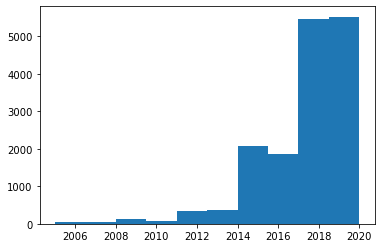

In [15]:
bedroom_df = cleaned_perth_df.loc[cleaned_perth_df["BEDROOMS"]== 4]
bedroom_df["YEAR_SOLD"] = bedroom_df["YEAR_SOLD"].astype(int)
# bedroom_df["YEAR_SOLD"].hist(bins = 1, range=[2000, 2010], grid=False)
plt.hist(bedroom_df["YEAR_SOLD"])

<AxesSubplot:>

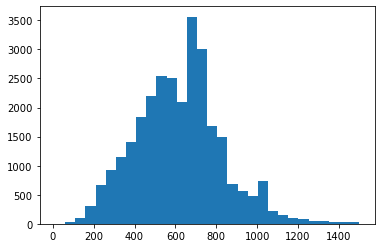

In [16]:
cleaned_perth_df["LAND_AREA"].hist(bins = 30, range=[10, 1500], grid=False)


In [17]:
cleaned_perth_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30330 entries, 0 to 33655
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ADDRESS           30330 non-null  object 
 1   SUBURB            30330 non-null  object 
 2   PRICE             30330 non-null  int64  
 3   BEDROOMS          30330 non-null  int64  
 4   LAND_AREA         30330 non-null  int64  
 5   BUILD_YEAR        27594 non-null  float64
 6   CBD_DIST          30330 non-null  int64  
 7   NEAREST_STN       30330 non-null  object 
 8   NEAREST_STN_DIST  30330 non-null  int64  
 9   LATITUDE          30330 non-null  float64
 10  LONGITUDE         30330 non-null  float64
 11  NEAREST_SCH       30330 non-null  object 
 12  NEAREST_SCH_DIST  30330 non-null  float64
 13  YEAR_SOLD         30330 non-null  int32  
dtypes: float64(4), int32(1), int64(5), object(4)
memory usage: 3.4+ MB


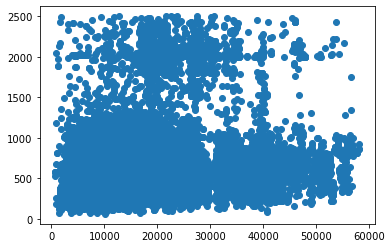

In [18]:
plt.scatter(cleaned_perth_df["CBD_DIST"], cleaned_perth_df["LAND_AREA"])

In [19]:
cleaned_perth_df["NEAREST_STN"].value_counts().head(10)

Midland Station             2826
Warwick Station             1675
Cockburn Central Station    1545
Butler Station              1136
Currambine Station          1109
Bull Creek Station          1057
Edgewater Station            970
Murdoch Station              950
Canning Bridge Station       855
Stirling Station             840
Name: NEAREST_STN, dtype: int64

# Correlation

In [20]:
midland = cleaned_perth_df.loc[cleaned_perth_df["NEAREST_STN"] == "Midland Station"]
midland_price = midland["PRICE"] / midland["LAND_AREA"]
midland_price

3         391.705069
16        527.903469
17       1003.521127
18        423.435419
34        295.857988
            ...     
33582     244.000000
33584     568.011958
33635     325.765054
33649    1167.500000
33655     996.621622
Length: 2826, dtype: float64

In [21]:
# Price vs. Midland Station distance
stats.pearsonr(midland_price,midland["NEAREST_STN_DIST"])

(-0.32338205310698576, 8.512312661474509e-70)

In [22]:
# Price vs. Station distance
stats.pearsonr(cleaned_perth_df["PRICE"],cleaned_perth_df["NEAREST_STN_DIST"])

(-0.15464502949873013, 1.1510028157438335e-161)

In [23]:
# Price vs. School distance
stats.pearsonr(cleaned_perth_df["PRICE"],cleaned_perth_df["NEAREST_SCH_DIST"])

(-0.08510649991805166, 7.160679095347973e-50)

In [24]:
# Price vs. School distance
stats.pearsonr(cleaned_perth_df["PRICE"],cleaned_perth_df["CBD_DIST"])

(-0.417768973791129, 0.0)

# Connect to SQL

In [28]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [44]:
from config import password

In [45]:
# Create the Database Engine - local server, the connection string will be as follows:
connection_string  = f"postgres:{password}@127.0.0.1:5432/Project_2"
    
# Create the database engine (to the PostgreSQL database)
engine = create_engine(f'postgresql://{connection_string}') 
conn = engine.connect()

In [46]:
# Query All Records in the the Database
data = engine.execute("SELECT * FROM address_price")

for record in data:
    print(record)

('1 Acorn Place, South Lake', 565000)
('1 Addis Way, Wandi', 365000)
('1 Ainsley Court, Camillo', 287000)
('1 Albert Street, Bellevue', 255000)
('1 Aman Place, Lockridge', 325000)
('1 Amethyst Crescent, Mount Richon', 409000)
('1 Ardara Lane, Hilbert', 400000)
('1 Arnside Bend, Waikiki', 370000)
('1 Arrochar Court, Hamersley', 565000)
('1 Arundel Street, Bayswater', 685000)
('1 Ashcott Gate, Butler', 367500)
('1 Ashcroft Way, Balga', 300000)
('1 Ashendon Boulevard, Hammond Park', 535000)
('1 Ashtree Boulevard, Wattle Grove', 540000)
('1 August Court, Bull Creek', 685000)
('1 Avonlea Place, Bullsbrook', 350000)
('1 Babbler Court, Maida Vale', 570000)
('1 Balga Place, Koongamia', 318000)
('1 Bamlett Street, Mount Nasura', 379000)
('1 Banken Court, Forrestdale', 387500)
('1 Barcroft Court, Atwell', 465000)
('1 Bates Loop, Lockridge', 325000)
('1 Batoni Way, Ashby', 515000)
('1 Bayley Street, Woodbridge', 610000)
('1 Beach Street, Bicton', 1950000)
('1 Beacon Way, Singleton', 420000)
('1 B

In [47]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine,reflect=True)

In [51]:
# We can view all of the classes that automap found
Base.classes.keys()

['address_suburb',
 'address_price',
 'address_bedrooms',
 'address_land',
 'address_buildyear',
 'address_cbddist',
 'address_latitude',
 'address_longitude',
 'address_nearestschool',
 'address_nearestschooldist',
 'address_neareststation',
 'address_neareststationdist',
 'address_yearsold',
 'perth_properties']

In [55]:
# Save references to each table
suburb = Base.classes.address_suburb


In [56]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

In [61]:
session.query(suburb).first().__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x22eeb6a1f98>,
 'address': '1 Acorn Place, South Lake',
 'suburb': 'South Lake'}

In [66]:
suburb_first_row = session.query(suburb.address, suburb.suburb).all()
suburb_first_row

[('1 Acorn Place, South Lake', 'South Lake'),
 ('1 Addis Way, Wandi', 'Wandi'),
 ('1 Ainsley Court, Camillo', 'Camillo'),
 ('1 Albert Street, Bellevue', 'Bellevue'),
 ('1 Aman Place, Lockridge', 'Lockridge'),
 ('1 Amethyst Crescent, Mount Richon', 'Mount Richon'),
 ('1 Ardara Lane, Hilbert', 'Hilbert'),
 ('1 Arnside Bend, Waikiki', 'Waikiki'),
 ('1 Arrochar Court, Hamersley', 'Hamersley'),
 ('1 Arundel Street, Bayswater', 'Bayswater'),
 ('1 Ashcott Gate, Butler', 'Butler'),
 ('1 Ashcroft Way, Balga', 'Balga'),
 ('1 Ashendon Boulevard, Hammond Park', 'Hammond Park'),
 ('1 Ashtree Boulevard, Wattle Grove', 'Wattle Grove'),
 ('1 August Court, Bull Creek', 'Bull Creek'),
 ('1 Avonlea Place, Bullsbrook', 'Bullsbrook'),
 ('1 Babbler Court, Maida Vale', 'Maida Vale'),
 ('1 Balga Place, Koongamia', 'Koongamia'),
 ('1 Bamlett Street, Mount Nasura', 'Mount Nasura'),
 ('1 Banken Court, Forrestdale', 'Forrestdale'),
 ('1 Barcroft Court, Atwell', 'Atwell'),
 ('1 Bates Loop, Lockridge', 'Lockridge')

In [70]:
suburb_list=[]
for row in suburb_first_row:
    stn_result = list(np.ravel(row))
    stn_dict = {"Station": stn_result[0], "Name":stn_result[1]}
    suburb_list.append(stn_dict)
suburb_list

('1 Acorn Place, South Lake', 'South Lake')
('1 Addis Way, Wandi', 'Wandi')
('1 Ainsley Court, Camillo', 'Camillo')
('1 Albert Street, Bellevue', 'Bellevue')
('1 Aman Place, Lockridge', 'Lockridge')
('1 Amethyst Crescent, Mount Richon', 'Mount Richon')
('1 Ardara Lane, Hilbert', 'Hilbert')
('1 Arnside Bend, Waikiki', 'Waikiki')
('1 Arrochar Court, Hamersley', 'Hamersley')
('1 Arundel Street, Bayswater', 'Bayswater')
('1 Ashcott Gate, Butler', 'Butler')
('1 Ashcroft Way, Balga', 'Balga')
('1 Ashendon Boulevard, Hammond Park', 'Hammond Park')
('1 Ashtree Boulevard, Wattle Grove', 'Wattle Grove')
('1 August Court, Bull Creek', 'Bull Creek')
('1 Avonlea Place, Bullsbrook', 'Bullsbrook')
('1 Babbler Court, Maida Vale', 'Maida Vale')
('1 Balga Place, Koongamia', 'Koongamia')
('1 Bamlett Street, Mount Nasura', 'Mount Nasura')
('1 Banken Court, Forrestdale', 'Forrestdale')
('1 Barcroft Court, Atwell', 'Atwell')
('1 Bates Loop, Lockridge', 'Lockridge')
('1 Batoni Way, Ashby', 'Ashby')
('1 Bayle